In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve, hinge_loss
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.utils import resample

## DATA PREPROCESSING

In [27]:
df = pd.read_csv('survey.csv')
#print(df.info())

In [28]:
#Data Cleaning
#Drop Country, States, Timestamp and comments
df=df.drop(['state'], axis= 1)
df=df.drop(['Country'], axis= 1)
df=df.drop(['Timestamp'], axis= 1)
df=df.drop(['comments'], axis= 1)

#Clean Null (NA) Value


StringFeature = ['Gender','self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']

for feature in df:
    if feature in StringFeature:
        df[feature]=df[feature].fillna('NaN')

#The following section is trying to standardize the Gender column and only include three types of elements: male, trans, female
# How many unique elements are there in Gender column
gender=df['Gender'].unique()
print(gender)

Male=['M','Male','male','m','Male-ish','maile','something kinda male?','Cis Male','Mal','Male (CIS)','Make','Male ','Man','msle','Mail','cis male','Malr','Cis Man']
Female=['Female','female','F','Cis Female','Woman','f','Female ','Femake','woman','cis-female/femme','Female (cis)','femail']
Trans=['Trans-female','something kinda male?','queer/she/they','non-binary','Nah',
 'All', 'Enby', 'fluid', 'Genderqueer','Androgyne','Agender','Guy (-ish) ^_^','Trans woman','Neuter', 'Female (trans)', 'queer','A little about you','ostensibly male, unsure what that really means','male leaning androgynous']
Unidentified=['A little about you','p']


for (row, col) in df.iterrows():

    if col.Gender in Male:
        df['Gender'].replace(to_replace=col.Gender, value='Male', inplace=True)

    if col.Gender in Female:
        df['Gender'].replace(to_replace=col.Gender, value='Female', inplace=True)

    if col.Gender in Trans:
        df['Gender'].replace(to_replace=col.Gender, value='Trans', inplace=True)

df = df[~df['Gender'].isin(Unidentified)] #Delete the rows with Unidentified value

#The following section is to use the median filling the rows with strange age value. (Strange Value: Less than 18, and 100)

#complete missing age with mean
df['Age'].fillna(df['Age'].median(), inplace = True)

# Fill with media() values < 18 and > 120
s = pd.Series(df['Age'])
s[s<18] = df['Age'].median()
df['Age'] = s
s = pd.Series(df['Age'])
s[s>100] = df['Age'].median()
df['Age'] = s

#Develop on new column Ranges of Age
df['age_range'] = pd.cut(df['Age'], [0,20,30,65,100], labels=["0-20", "21-30", "31-65", "66-100"], include_lowest=True)

#Replace the NaN value in self_employed column with No
df['self_employed']=df['self_employed'].replace('NaN','No')

#Delete NaN value in work_interfere column since we would assume those are normal people 
Value=['NaN']
df=df[~df['work_interfere'].isin(Value)]

['Female' 'M' 'Male' 'male' 'female' 'm' 'Male-ish' 'maile' 'Trans-female'
 'Cis Female' 'F' 'something kinda male?' 'Cis Male' 'Woman' 'f' 'Mal'
 'Male (CIS)' 'queer/she/they' 'non-binary' 'Femake' 'woman' 'Make' 'Nah'
 'All' 'Enby' 'fluid' 'Genderqueer' 'Female ' 'Androgyne' 'Agender'
 'cis-female/femme' 'Guy (-ish) ^_^' 'male leaning androgynous' 'Male '
 'Man' 'Trans woman' 'msle' 'Neuter' 'Female (trans)' 'queer'
 'Female (cis)' 'Mail' 'cis male' 'A little about you' 'Malr' 'p' 'femail'
 'Cis Man' 'ostensibly male, unsure what that really means']


In [29]:
#Encoding data with Label Encoder
#Dataset dflabel is the one with Label Encoder

dflabel=df
labelDict = {}
for feature in ['Gender','self_employed', 'family_history', 'treatment',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help','age_range']:
    le = preprocessing.LabelEncoder()
    le.fit(dflabel[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    dflabel[feature] = le.transform(dflabel[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
#for key, value in labelDict.items():     
#    print(key, value)

In [30]:
#Scaling the Age
scaler = MinMaxScaler() # maps age values to interval [0,1] with 1 being maximum and 0 min to standardize
df['Age'] = scaler.fit_transform(df[['Age']])
df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.351852,0,0,0,1,Often,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,0.481481,1,0,0,0,Rarely,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,0.259259,1,0,0,0,Rarely,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,0.240741,1,0,1,1,Often,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,0.240741,1,0,0,0,Never,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


In [31]:
df['suffer_but_no_treatment']=0 # this is our y variable
for index, row in df.iterrows():
    if (row['work_interfere'] == 'Often' or row['work_interfere'] == 'Sometimes') and (row['treatment'] == 0):
        df['suffer_but_no_treatment'][index]=1

C:\Users\jiang\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [32]:
print("Total number of ppl whose work is interfered 'often' or 'sometimes' but have received no treatment: ", 
      np.sum(df['suffer_but_no_treatment']) , "out of", len(df))

Total number of ppl whose work is interfered 'often' or 'sometimes' but have received no treatment:  128 out of 994


In [33]:
# we want to predict sufferers based on lacking this knowledge, so we drop it
df = df.drop('work_interfere',axis=1)
df = df.drop('treatment',axis=1)
x=df.iloc[:,:-1]
y=df['suffer_but_no_treatment']

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

## FEATURE SELECTION

Because we should penalize false negatives much more than false positives, we want a high sensitivity (reflects the model's ability to identify people who are in an unhealthy mental condition) or $$sensitivity = \frac{TP}{TP + FN}$$

In [35]:
def accuracy_score(y_test, predictions):
    tp = 0; tn = 0; fp = 0; fn = 0
    for index, (true, pred) in enumerate(zip(y_test, predictions)):
        if true==1 and pred==1:
            tp += 1
        elif true==0 and pred==0:
            tn += 1
        elif true==0 and pred==1:
            fp += 1
        elif true==1 and pred==0:
            fn += 1
    print('(tp, tn, fp, fn): ', tp, tn, fp, fn)
    sensitivity = tp / (tp+fn)
    return sensitivity

#### As a baseline, look at random forest model performance with all 22 features

In [36]:
rf0 = RandomForestClassifier(random_state=43)      
rf0 = rf0.fit(x_train,y_train)

ac = accuracy_score(y_test,rf0.predict(x_test))
print('Accuracy is: ',ac)

(tp, tn, fp, fn):  0 90 1 9
Accuracy is:  0.0


#### Decide optimal # of features based on Recursive feature elimination

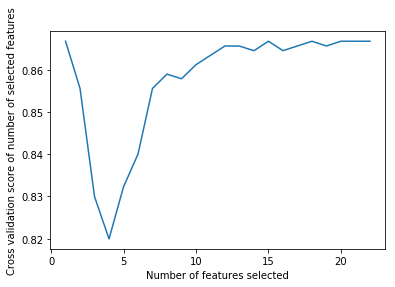

In [25]:
rf1=RandomForestClassifier() 
rfecv=RFECV(estimator=rf1,step=1,cv=10,scoring='accuracy')
rfecv=rfecv.fit(x_train,y_train)
#print('Optimal number of features :', rfecv.n_features_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

**Optimal # of features ~ 14**

#### Feature subsel. from Correlation Analysis

In [37]:
# Correlation Analysis
featurea=['Age', 'family_history', 'benefits', 'care_options', 'anonymity', 
          'Gender', 'mental_health_interview', 'phys_health_interview', 
          'coworkers', 'seek_help', 'wellness_program', 'leave', 
          'mental_vs_physical', 'tech_company']

In [38]:
x1_train=x_train[featurea]
x1_test=x_test[featurea]
rf2 = RandomForestClassifier(random_state=43)      
rf2 = rf2.fit(x1_train,y_train)

ac = accuracy_score(y_test,rf2.predict(x1_test))
print('Accuracy is: ',ac)

(tp, tn, fp, fn):  0 89 2 9
Accuracy is:  0.0


#### Feature subsel. from Tree-based feature sel.

Feature ranking:
1. feature 0 (0.150354)
2. feature 4 (0.077457)
3. feature 12 (0.068701)
4. feature 8 (0.054478)
5. feature 7 (0.053404)
6. feature 13 (0.049989)
7. feature 18 (0.049736)
8. feature 16 (0.049618)
9. feature 19 (0.048760)
10. feature 10 (0.044372)
11. feature 15 (0.042836)
12. feature 3 (0.037497)
13. feature 14 (0.037392)
14. feature 9 (0.032120)
15. feature 11 (0.030101)
16. feature 21 (0.029366)
17. feature 5 (0.027653)
18. feature 1 (0.027651)
19. feature 17 (0.023745)
20. feature 6 (0.022939)
21. feature 2 (0.021917)
22. feature 20 (0.019913)


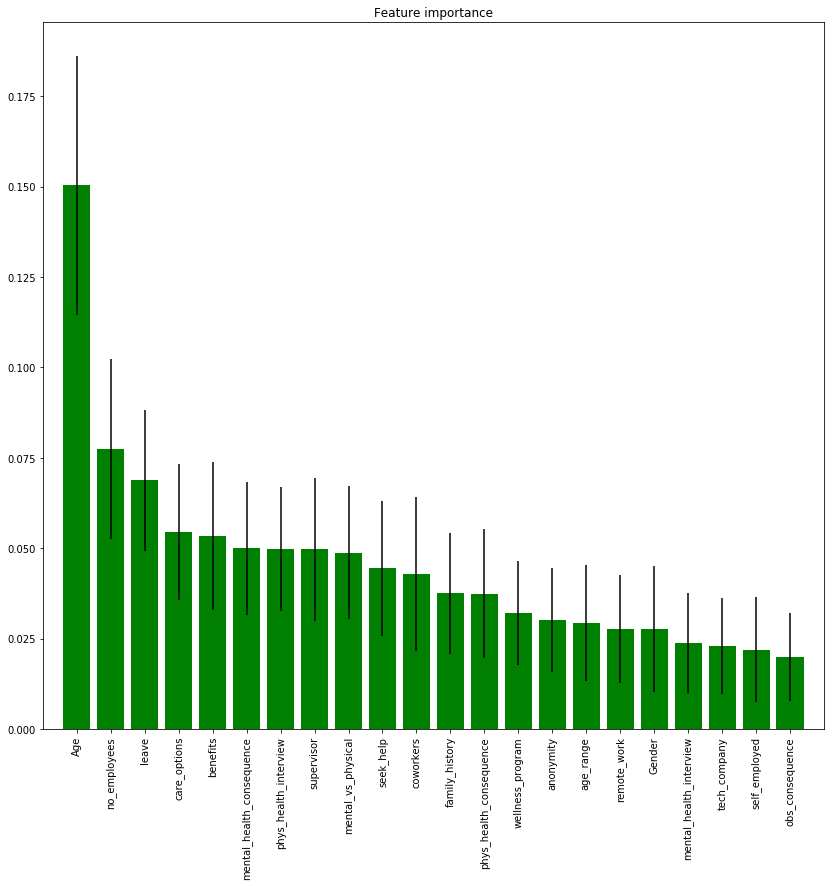

In [39]:
#Tree-based feature selection and random forest classification
rf2=RandomForestClassifier()
rf2=rf2.fit(x_train,y_train)
importance=rf2.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf2.estimators_], axis=0)
indices = np.argsort(importance)[::-1]

print("Feature ranking:")

for f in range(x_train.shape[1]):
    
    print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))
plt.figure(1, figsize=(14, 13))
plt.title("Feature importance")
plt.bar(range(x_train.shape[1]), importance[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

In [40]:
featureb=['Age','no_employees','leave','benefits',
         'mental_health_consequence','phys_health_interview','supervisor','mental_vs_physical',
         'care_options','coworkers','seek_help','phys_health_consequence',
         'family_history','wellness_program']

In [41]:
x2_train=x_train[featureb]
x2_test=x_test[featureb]
rf3 = RandomForestClassifier(random_state=43)      
rf3 = rf3.fit(x2_train,y_train)

ac = accuracy_score(y_test,rf3.predict(x2_test))
print('Accuracy is: ',ac)

(tp, tn, fp, fn):  0 90 1 9
Accuracy is:  0.0


#### Feature subsel. from Univariate Feature Selection

In [42]:
select_feature = SelectKBest(chi2, k=14).fit(x_train, y_train)
print('Score list:', select_feature.scores_)
print('Feature list:', x_train.columns)

Score list: [1.65866558e-01 2.41573528e-01 1.39354927e+00 8.12068045e-01
 1.58230330e-01 1.80739042e-01 1.86709370e-01 9.46181660e+00
 1.16350400e+01 1.16276221e-02 2.41551731e-03 1.17630095e+01
 6.94269980e-01 9.81964550e-01 3.88484100e-01 1.93331108e+00
 5.98275967e-01 2.45438099e-02 1.73530247e+00 1.17010242e+00
 9.08944863e-01 2.25925536e-02]
Feature list: Index(['Age', 'Gender', 'self_employed', 'family_history', 'no_employees',
       'remote_work', 'tech_company', 'benefits', 'care_options',
       'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence', 'phys_health_consequence', 'coworkers',
       'supervisor', 'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'age_range'],
      dtype='object')


In [43]:
featurec = ['Age', 'Gender', 'self_employed', 'family_history', 'no_employees',
       'remote_work', 'tech_company', 'benefits', 'care_options',
       'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence', 'phys_health_consequence', 'coworkers',
       'supervisor', 'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'age_range'][:14]

In [46]:
x3_train=x_train[featurec]
x3_test=x_test[featurec]
rf4 = RandomForestClassifier()      
rf4 = rf4.fit(x3_train,y_train)

ac = accuracy_score(y_test,rf4.predict(x3_test))
print('Accuracy is: ',ac)

(tp, tn, fp, fn):  2 91 0 7
Accuracy is:  0.2222222222222222


#### Conclusion (Feature subselection): It appears that the 14 best features learned by the 3rd method (via univariate feature subselection) returned even better results than a model trained with all 22 features. We will thus use feature C for further models below, and the random forest classifier as a sort of baseline for comparison.

### MODEL BUILDING
(Linear regression, logisitic regression, regularization, bootstrapping, GLRMs)

#### One hot encode

In [47]:
x_encoded = x[featurec]
x_encoded=df.iloc[:,1:-1]
age=df['Age']
y=df['suffer_but_no_treatment']

enc = preprocessing.OneHotEncoder()
T=enc.fit(x_encoded)
x_encoded = enc.transform(x_encoded).toarray()

new_df = pd.DataFrame(x_encoded).convert_dtypes('bin')
new_age = pd.DataFrame(age.to_numpy())
x_encoded = pd.concat([new_age, new_df], axis=1, ignore_index=True)

In [52]:
x_encoded_train, x_encoded_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.1, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

#### Models

In [53]:
# Try out linear regression
reg = LinearRegression()
reg.fit(x_train, y_train)
predictions = [0 if x<0.5 else 1 for x in reg.predict(x_test)]
accuracy_score(y_test, predictions)

(tp, tn, fp, fn):  0 91 0 9


0.0

In [54]:
# Wow that's awful! How about adding some regularization?
ridge = Ridge(alpha=1).fit(x_train, y_train) 
ridge.fit(x_train, y_train)
predictions = [0 if x<0.5 else 1 for x in ridge.predict(x_test)]
accuracy_score(y_test, predictions)

(tp, tn, fp, fn):  0 91 0 9


0.0

In [55]:
logit = LogisticRegression()
logit.fit(x_train, y_train)
predictions = [0 if x<0.5 else 1 for x in logit.predict(x_test)]
accuracy_score(y_test, predictions)

(tp, tn, fp, fn):  0 91 0 9


0.0